# Gaussian Mixture Model (GMM) 
This notebook walks through how to implement a popular latent variable model (with discrete latent variable) in Python and demonstrates how to fit/train the model on a synthetic dataset as well as a digit dataset.

- Date: Nov 8, 2020
- Author: hjsong


## Problem setup 
We have a set of data observed $X = {X^{(n)}}$, and assume that each data point $x$ has a latent variable $z$, and $(x,z)$ is associated with an (identical) distribution p(x,z) s.t. $p(x,z) = \sum_{k} \pi_k N(x | \mu_k, \Sigma_k)$. 
- Model parameters: $\pi = [\pi_1, \dots \pi_K], \mathbf{\mu} = \{\mu_1, \dots \mu_K\}, \mathbf{\Sigma} = \{\Sigma_1, \dots, \Sigma_K\}$

- Our goal is to fit the model parameters to the observed data $X$ under the maximum-likelihood criterion:
$J(\theta) =$

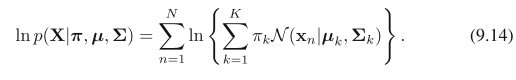

- Typically, we fit the model parameters by taking a gradient of this (multivariate) objective function $J$, set each partial derivatives to zero, and solve each of the equations (one for each variate/argument variable in the objective function). If we do so for the GMM, we get the following systems of equations:

    1. Set Gradient wrt. $\pi$ to zero:

    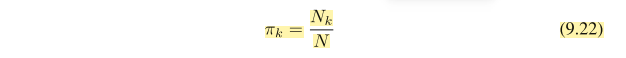    

    2. Set Gradient wrt. $\{mu_k\}$ to zero: 

    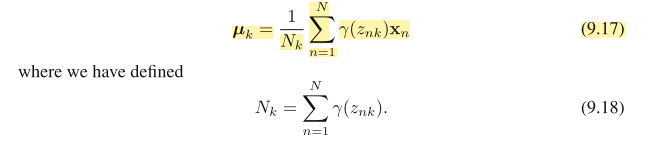
    
    3. Set Graident wrt. $\{\Sigma_k\}$ to zero:

    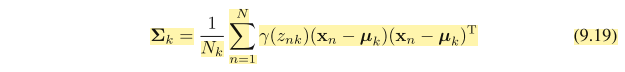
    
    
Notice that all three partial derivatives (wrt. each model parameter) depend on the same quantity $\{r_{nk}\}$.
We interpret $r_{nk}$ as the posterior probability of a data variable $x^{(n)}$ being in cluster $k$. Alternatively, we may view $r_n$ as a discrete probability function in K-dimension, each of its kth component indicates the posterior probability of the data variable x belong to kth cluster. However, the set of $r_{nk}$ values are not observed (aka. $\{r_{nk}\}$ is a latent variable in this model. Therefore, we cannot solve for 1,2,3 above. Yet, if we assume we know $\{r_{nk}\}$ values, then solving 1,2,3 is easy -- we have an analytic soltuion for each equation. 

Thankfully, the relationship between $\{r_{nk}\}$ and the model parameters is perfect for an iterative optimization framework, because given the model parameters, computing the posterior probabilities $\{r_{nk} \}$ is also straightforward (ie. we have an analytical equation to compute the posteriors, given model parameters known and observed data variables):

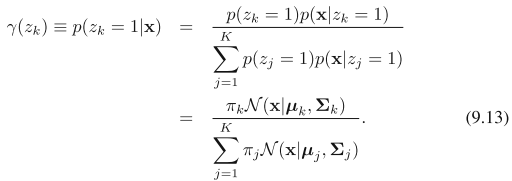



Given this relationship between the model parameters and posterior probabilities of the latent variable given the model parameter and data variables, we can solve the optimization problem (of finding a best values of the model parameters to maximize the objective function $J$) via an iterative method:

## Learning Algorithm for GMM
1. Initially, set the model parameters to some initial guesses
    - Eg. Run KMeans on the dataset and use the discovered prototype vectors (ie. $\mu_k$ ) as the initial values of the centers of the gaussian component distributions.
    - Eg. Set the covariance matrix of each gaussian component distribution $\Sigma_k$ to be proportional to a unit, diagonal cov. matrix 
    
2. Given the model parameters (and the observed data), compute the posterior probabilities $\{r_{nk}\}$, as described in Eqn. 9.13 -- "Estep"
3. Given the current posterior probabilities and observed data, re-estimate/update/compute the argmaxing values of model parameters as describe in Eqn. 9.17, 19, 22 -- "Mstep" 

4. Iterate until the model parameters don't change much, the loglikelihood of observed data doesn't improve much, or max iteration is reached. 
    
    

## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %reset out

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd
# import geopandas as gpd
import joblib

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from skimage.color import rgb2gray
from skimage.transform import resize

from pprint import pprint
from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union

# import pdb
from ipdb import set_trace


In [ ]:
# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
# from torchvision import datasets, transforms
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Normal
assert pyro.__version__.startswith('1.5.0')
pyro.enable_validation(True)    # <---- This is always a good idea!

## Helpers

In [ ]:
def now2str():
    now = datetime.now()
    now_str = now.strftime("%m_%d_%H:%M:%S")
    return now_str

# np.ndarray to pretty text
UPPER_LEFT = u'\u250c'
UPPER_RIGHT = u'\u2510'
LOWER_LEFT = u'\u2514'
LOWER_RIGHT = u'\u2518'
HORIZONTAL = u'\u2500'
VERTICAL = u'\u2502'

def upper_line(width):
    return UPPER_LEFT + HORIZONTAL * width + UPPER_RIGHT

def lower_line(width):
    return LOWER_LEFT + HORIZONTAL * width + LOWER_RIGHT

def left_line(height):
    return "\n".join([UPPER_LEFT] + [VERTICAL] * height + [LOWER_LEFT])

def right_line(height):
    return "\n".join([UPPER_RIGHT] + [VERTICAL] * height + [LOWER_RIGHT])

def nd2str(A, w=None, h=None):
    """Returns a string to pretty print the numpy.ndarray `A`.

    Currently supports 1 - 3 dimensions only.
    Raises a NotImplementedError if an array with more dimensions is passed.

    Describe `w` and `h`.
    """
    if A.ndim == 1:
        if w is None:
            return str(A)
        s = " ".join([str(value).rjust(width) for value, width in zip(A, w)])
        return '[{}]'.format(s)
 
    elif A.ndim == 2:
        widths = [max([len(str(s)) for s in A[:, i]]) for i in range(A.shape[1])]
        s = "".join([' ' + nd2str(AA, w=widths) + ' \n' for AA in A])
        w0 = sum(widths) + len(widths) - 1 + 2 # spaces between elements and corners
#         return upper_line(w0) + '\n'  + s + lower_line(w0)
        return s # cocoaaa: I prefer no uppler and lower lines

    elif A.ndim == 3:
        h = A.shape[1]
        strings = [left_line(h)]
        strings.extend(nd2str(a) + '\n' for a in A)
        strings.append(right_line(h))
        return '\n'.join(''.join(pair) for pair in zip(*map(str.splitlines, strings)))
    
    raise NotImplementedError("Currently only 1 - 3 dimensions are supported")

def ppnd(A, **kwargs):
    print(nd2str(A,**kwargs))
    
def info(arr, header=None):
    if header is None:
        header = "="*30
    print(header)
    print("shape: ", arr.shape)
    print("dtype: ", arr.dtype)
    print("min, max: ", min(np.ravel(arr)), max(np.ravel(arr)))

In [ ]:
#  src: https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/
from matplotlib.patches import Ellipse

def get_cov_ellipse(cov, centre, n_std, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor n_std.

    Usage:
    e = get_cov_ellipse(cov, (height_mean, mass_mean), 3,
                        fc=colours[gender], alpha=0.4)
    ax.add_artist(e)
    """
    if  isinstance(centre, np.ndarray) and centre.ndim == 2:
        centre = centre.flatten()
        
    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * n_std * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


In [ ]:
def get_params(model_params: Mapping[str, Iterable], as_tensor=False) -> Iterable[Iterable]:
    if as_tensor:
        model_params = {k:torch.tensor(v, dtype=torch.float32) for k,v in model_params.items()}
    return model_params['pi'], model_params['mu0'], model_params['sigma0'], model_params['mu1'], model_params['sigma1']

In [ ]:
def visualize_2d_gaussian_ellipse(
    mu:Union[torch.Tensor, np.ndarray], cov:Union[torch.Tensor, np.ndarray], n_std=1, 
    xlim: Optional[Iterable]=None, ylim: Optional[Iterable]=None, n:int=100, 
    **kwargs):
    
    if isinstance(mu, torch.Tensor):
        mu = mu.numpy()
    if isinstance(cov, torch.Tensor):
        cov = cov.numpy()
        
    # Compute eigenvalues of the cov matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    max_eigval = eigvals[0]
    
    # default xlim is +/- 3std(ish)
    if xlim is None:
        xlim = (mu[0] - 3*max_eigval, mu[0] + 3*max_eigval) 
    if ylim is None:
        ylim = (mu[1] - 3*max_eigval, mu[1] + 3*max_eigval) 
    
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * n_std * np.sqrt(eigvals)
    e = Ellipse(xy=mu, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)
    # Plot
    f, ax = plt.subplots()
    ax.scatter(mu[0],mu[1],label=f'{mu}',s=10,c='b')
    ax.add_artist(e)
    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()
    
    return f
    


In [ ]:
def visualize_2d_gaussian(mu:torch.Tensor, cov:torch.Tensor,  *,
                          xlim: Iterable, ylim:Iterable, n:int, **kwargs):
    
    d = MultivariateNormal(mu, cov)
    
    # Make a grid to evaluate the (log) probabilities
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    xx,yy = np.meshgrid(x,y)
    points = np.vstack([xx.ravel(), yy.ravel()]).T

    # log probabilities
    log_ps = d.log_prob(torch.tensor(points, dtype=torch.float32))
    zz = log_ps.reshape(xx.shape)
    
    f,ax=plt.subplots()
    ax.contourf(xx,yy,zz, **kwargs)
    
    ax.scatter(mu[0], mu[1], s=10, c='r')
    
    title = f'mu:{mu.numpy()},cov: \n{ppnd(cov.numpy())}'
    ax.set_title(title)
    ax.set_aspect('equal')#, 'datalim')
    
    return f
    
    
def test_visualize_2d_gaussian_1():
    mu = torch.tensor([0.0,1.0])
    cov = torch.eye(2)
    visualize_2d_gaussian(mu, cov, xlim=(-10,10), ylim=(-10,10), n=100)
    
def test_visualize_2d_gaussian_2():
    mu = torch.tensor([-1.0,-1.0])
    cov = torch.eye(2)
    visualize_2d_gaussian(mu, cov, xlim=(-10,10), ylim=(-10,10), n=100)

def test_visualize_2d_gaussian_3():
    "axis-aligned cov w/ diag=[1,2]"
    mu = torch.tensor([0.0,0.0])
    cov = torch.tensor([[1.,0.], [0., 2.0]])
    visualize_2d_gaussian(mu, cov, xlim=(-10,10), ylim=(-10,10), n=100)

def test_visualize_2d_gaussian_4():
    "skewed cov"
    mu = torch.tensor([0.0,0.0])
    cov = torch.tensor([[1.,3./5.], [3./5., 1.0]])
    levels=10
#     cov = torch.tensor([[1.,3./5.], [3./5., 2.0]]) #also a valid cov matrix

    visualize_2d_gaussian(mu, cov, xlim=(-10,10), ylim=(-10,10), n=100, levels=levels)
    
test_visualize_2d_gaussian_2()
    

In [ ]:
def visualize_model(model_params: Dict[str,np.array],
                   dx=10, dy=10):
    # get parameters
    pi, mu0, sigma0, mu1, sigma1 = get_params(model_params)
    
    # to numpy
    if isinstance(mu0, torch.Tensor):
        mu0 = mu0.detach().numpy()
    if isinstance(mu1, torch.Tensor):
        mu1 = mu1.detach().numpy()
    if isinstance(sigma0, torch.Tensor):
        sigma0 = sigma0.detach().numpy()
    if isinstance(sigma1, torch.Tensor):
        sigma1 = sigma1.detach().numpy()

    xmin = min(mu0[0]-dx//2, mu1[0]-dx//2)
    xmax = max(mu0[0]+dx//2, mu1[0]+dx//2)
    ymin = min(mu0[1]-dy//2, mu1[1]-dy//2)
    ymax = max(mu0[1]+dy//2, mu1[1]+dy//2)
    e0 = get_cov_ellipse(sigma0, mu0, 1, fc='r', alpha=0.3)
    e1 = get_cov_ellipse(sigma1, mu1, 1, fc='b', alpha=0.3)

    f, ax = plt.subplots()
    ax.scatter(mu0[0],mu0[1],label='0',s=10,c='r')
    ax.scatter(mu1[0],mu1[1],label='1',s=10,c='b')
    ax.add_artist(e0)
    ax.add_artist(e1)
    ax.set_aspect('equal')
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    ax.legend()
    
    return f
    
def test_visualize_model():
    # Initial guess of the model parameters 
    m_pi = [0.5, 0.5]

    m_mu0 =  np.random.randn(2) # Use the result of KMeans
    m_sigma0 =  np.array([[1.,0.],[0.,1.]])# unit, diag covariance

    m_mu1 = np.random.randn(2)
    m_sigma1 = np.array([[1.,0.],[0.,1.]])# unit, diag covariance


    model_params = {'pi': m_pi,
                   'mu0': m_mu0,
                   'sigma0': m_sigma0,
                   'mu1': m_mu1,
                   'sigma1': m_sigma1}
    visualize_model(model_params);
    

In [ ]:
test_visualize_model()

## Dataset
Ref: [sklearn: Density Estimation for a Gaussian mixture](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py)

To create 2dim samples from a gaussian distrituion, use:

    `np.random.multivariate_normal(mean, cov, n_samples)` --> np.array of sizse (n_sample, 2)

In [ ]:
# Ground truth: two underlying population (ie. K=2)
# Component gaussian distribution 1: mu_1 = [1., 0], Sigma_1 = [[1,0], [2,0]]
# Component gaussian distribution 2: mu_2 = [0.0, 5.], Sigma_2 = [[2,0],[0., 2]]
# pi = [pi_1, pi_2]: ratio of each component 
# N: number of data points
# K: number of clusters 
# D: dimensionality of a data variable

N = 100
pi = [0.2, 0.8]
N0 = int(N*pi[0])
N1 = N-N0

K = 2
D = 2

# First gaussian component distribution
mu0 = np.array([2., 2.])
sigma0 = np.array([[1,0], [0,1.]])
sample0 = np.random.multivariate_normal(mean=mu0, cov=sigma0, size=N0)

# Second component distribution
mu1 = np.array([-3., -2])
sigma1 = np.array([[1,0.5],[0.5, 1]])
sample1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=N1)

X = np.vstack([sample0, sample1])
print(X.shape)



In [ ]:
plt.scatter(X[:N0,0], X[:N0,1], c='r', s=10, label='0')
plt.scatter(X[N0:,0], X[N0:,1], c='b', s=10, label='1')
plt.legend()
plt.title('Ground-Truth labels')
plt.gca().set_aspect('equal')

## Fit a GMM to this dataset
First, initial guess of the model parameters

In [ ]:
# Initial guess of the model parameters 
m_pi = [0.5, 0.5]

m_mu0 =  np.random.randn(2) # Use the result of KMeans
m_sigma0 =  np.array([[1.,0.],[0.,1.]])# unit, diag covariance

m_mu1 = np.random.randn(2)
m_sigma1 = np.array([[1.,0.],[0.,1.]])# unit, diag covariance


model_params = {'pi': m_pi,
               'mu0': m_mu0,
               'sigma0': m_sigma0,
               'mu1': m_mu1,
               'sigma1': m_sigma1}
visualize_model(model_params);

In [ ]:
def compute_posterior(X: torch.Tensor, model_params: Mapping[str,Iterable]) -> torch.Tensor:
    """
    Returns the posterior probabilities of {r_nk}:
    - r (torch.Tensor): of size (len(X), K=num_of_mixtures=2)
    
    """
    N, D = X.shape
    
    # get parameters
    pi, mu0, sigma0, mu1, sigma1 = get_params(model_params, as_tensor=True)
    assert len(mu0) == D 
    assert len(mu1) == D
    
    gauss0 = MultivariateNormal(mu0, sigma0)
    gauss1 = MultivariateNormal(mu1, sigma1)
    
    prob0 = gauss0.log_prob(X).exp().reshape((-1,1))
    prob1 = gauss1.log_prob(X).exp().reshape((-1,1))
    
    denom = pi[0]*prob0 + pi[1]*prob1
    
#     print(prob0.shape, denom.shape)
    r = torch.hstack([pi[0]*prob0/denom, pi[1]*prob1/denom])
    assert np.allclose(r.sum(1), 1.)
    
    return r


def test_compute_posterior():
    X = torch.tensor([[2., 2.]])
    mu0 = np.array([2.,2.])
    sigma0 = np.eye(2)
    mu1 = np.array([-2,-2])
    sigma1 = np.eye(2)
    pi = np.array([0.5,0.5])
    model_params = {'mu0':mu0, 'sigma0':sigma0,
                   'mu1':mu1, 'sigma1':sigma1,
                   'pi':pi}
    print(compute_posterior(X, model_params))
    
test_compute_posterior() # posterior probability of this point belonging to the first gaussian must be very close to 1 and to the 2nd gaussian to be very close to 0

In [ ]:
def check_data_contains(X: torch.Tensor, mu: torch.Tensor) -> bool:
    assert X.shape[-1] == mu.numel()
    for row in X:
        print(row, row.shape)
        if torch.isclose(row, mu).all():
            return True
    return False

In [ ]:
def update_model_params(X: torch.Tensor, R: torch.Tensor) -> Dict[str, torch.Tensor]:
    """
    Returns a new dictionary with updated parameter values as np.ndarray's
    
    
    - See https://stats.stackexchange.com/a/359730 for discussion on gaussian collapsing 
    in MoG under Max.Likelihood criteria,and what heuristics to use to avoid singularities 
    (ie. covariance of a gaussian dist == zero matrix)
    """
    N, D = X.shape
    sigma_heuristic_scale = (X.max() - X.min())/2
    if torch.isclose(sigma_heuristic_scale, torch.tensor(0.)):
        sigma_heuristic_scale = torch.tensor(1.0)
    # Update mu's
    Nk = R.sum(0)
    mu0 = (X * R[:,[0]]).sum(0).div(Nk[0])# 1dim
    mu1 = (X * R[:,[1]]).sum(0).div(Nk[1])# 1dim
    assert mu0.numel()==D
    assert mu1.numel()==D
    
    
    # Update cov's -- debug (check broadcasting -- currently all values are the same)
    # Caveat: if center of either gaussian is exactly the same as any of the datapoints, that gaussian's sigma may 
    # end up -> 0, ie. the gaussian may collapse to a dirac function at that data point. 
    #    --> See. PRML ch9 for the consequence of this in MoG under Max.Likelihood principle/criteria
    #    -- This phenomenon where one of the gaussian collapses to a data point is called "singularity"
    # One way to avoid the singularity to happen during the iterative MoG learning algorithm here is to
    # 1. use a bayesian approach (Sec 10.1 PRML: Variational Inference)
    # Or, 2. use a heuristic as below
    if check_data_contains(X, mu0):
        print("Warning: singularity occured. Setting mean to a random value and cov to a diag. mtx")
        # set mean to a random value
        mu0 = torch.rand_like(mu0)
        # set sigma to some randomly large value
        sigma0 = torch.diag(torch.randn(D)*sigma_heuristic_scale)
    else:
        sigma0 = torch.zeros(D,D)
        # Regular MLE fitting step
        for n in range(N): # or transpose not right?
            sigma0 += (torch.matmul((X[[n]]-mu0).T, X[[n]]-mu0)) * R[n,0] # Trick: X[array_indexing] -> maintains the original matrix X's dimensionality
        sigma0 *= (1/Nk[0])

    if check_data_contains(X, mu1):
        print("Warning: singularity occured. Setting mean to a random value and cov to a diag. mtx")
        # set mean to a random value
        mu1 = torch.rand_like(mu1)
        # set sigma to some randomly large value
        sigma1 = torch.diag(torch.randn(D)*sigma_heuristic_scale)
        
    else:
        sigma1 = torch.zeros(D,D)
        for n in range(N):
            sigma1 += (torch.matmul((X[[n]]-mu1).T, X[[n]]-mu1)) * R[n,1]
        sigma1*= (1/Nk[1])

    # Update pi
    pi = Nk/N
    
    return {'pi': Nk/N, 'mu0': mu0, 'sigma0':sigma0, 'mu1':mu1, 'sigma1':sigma1}


def test_update_model_params():
    X = torch.tensor([[2., 2.],
                     [1., 1.]])
    R = torch.tensor([[0.5,0.5],
                     [0.9, 0.1]])
    print("X: "); ppnd(X.numpy())
    print("R: "); ppnd(R.numpy())
    
    print(update_model_params(X, R))
    
test_update_model_params()

- Caveat: if center of either gaussian is exactly the same as any of the datapoints, that gaussian's sigma may end up -> 0, ie. the gaussian may collapse to a dirac function at that data point. 
    - See. PRML ch9 for the consequence of this in MoG under Max.Likelihood principle/criteria

    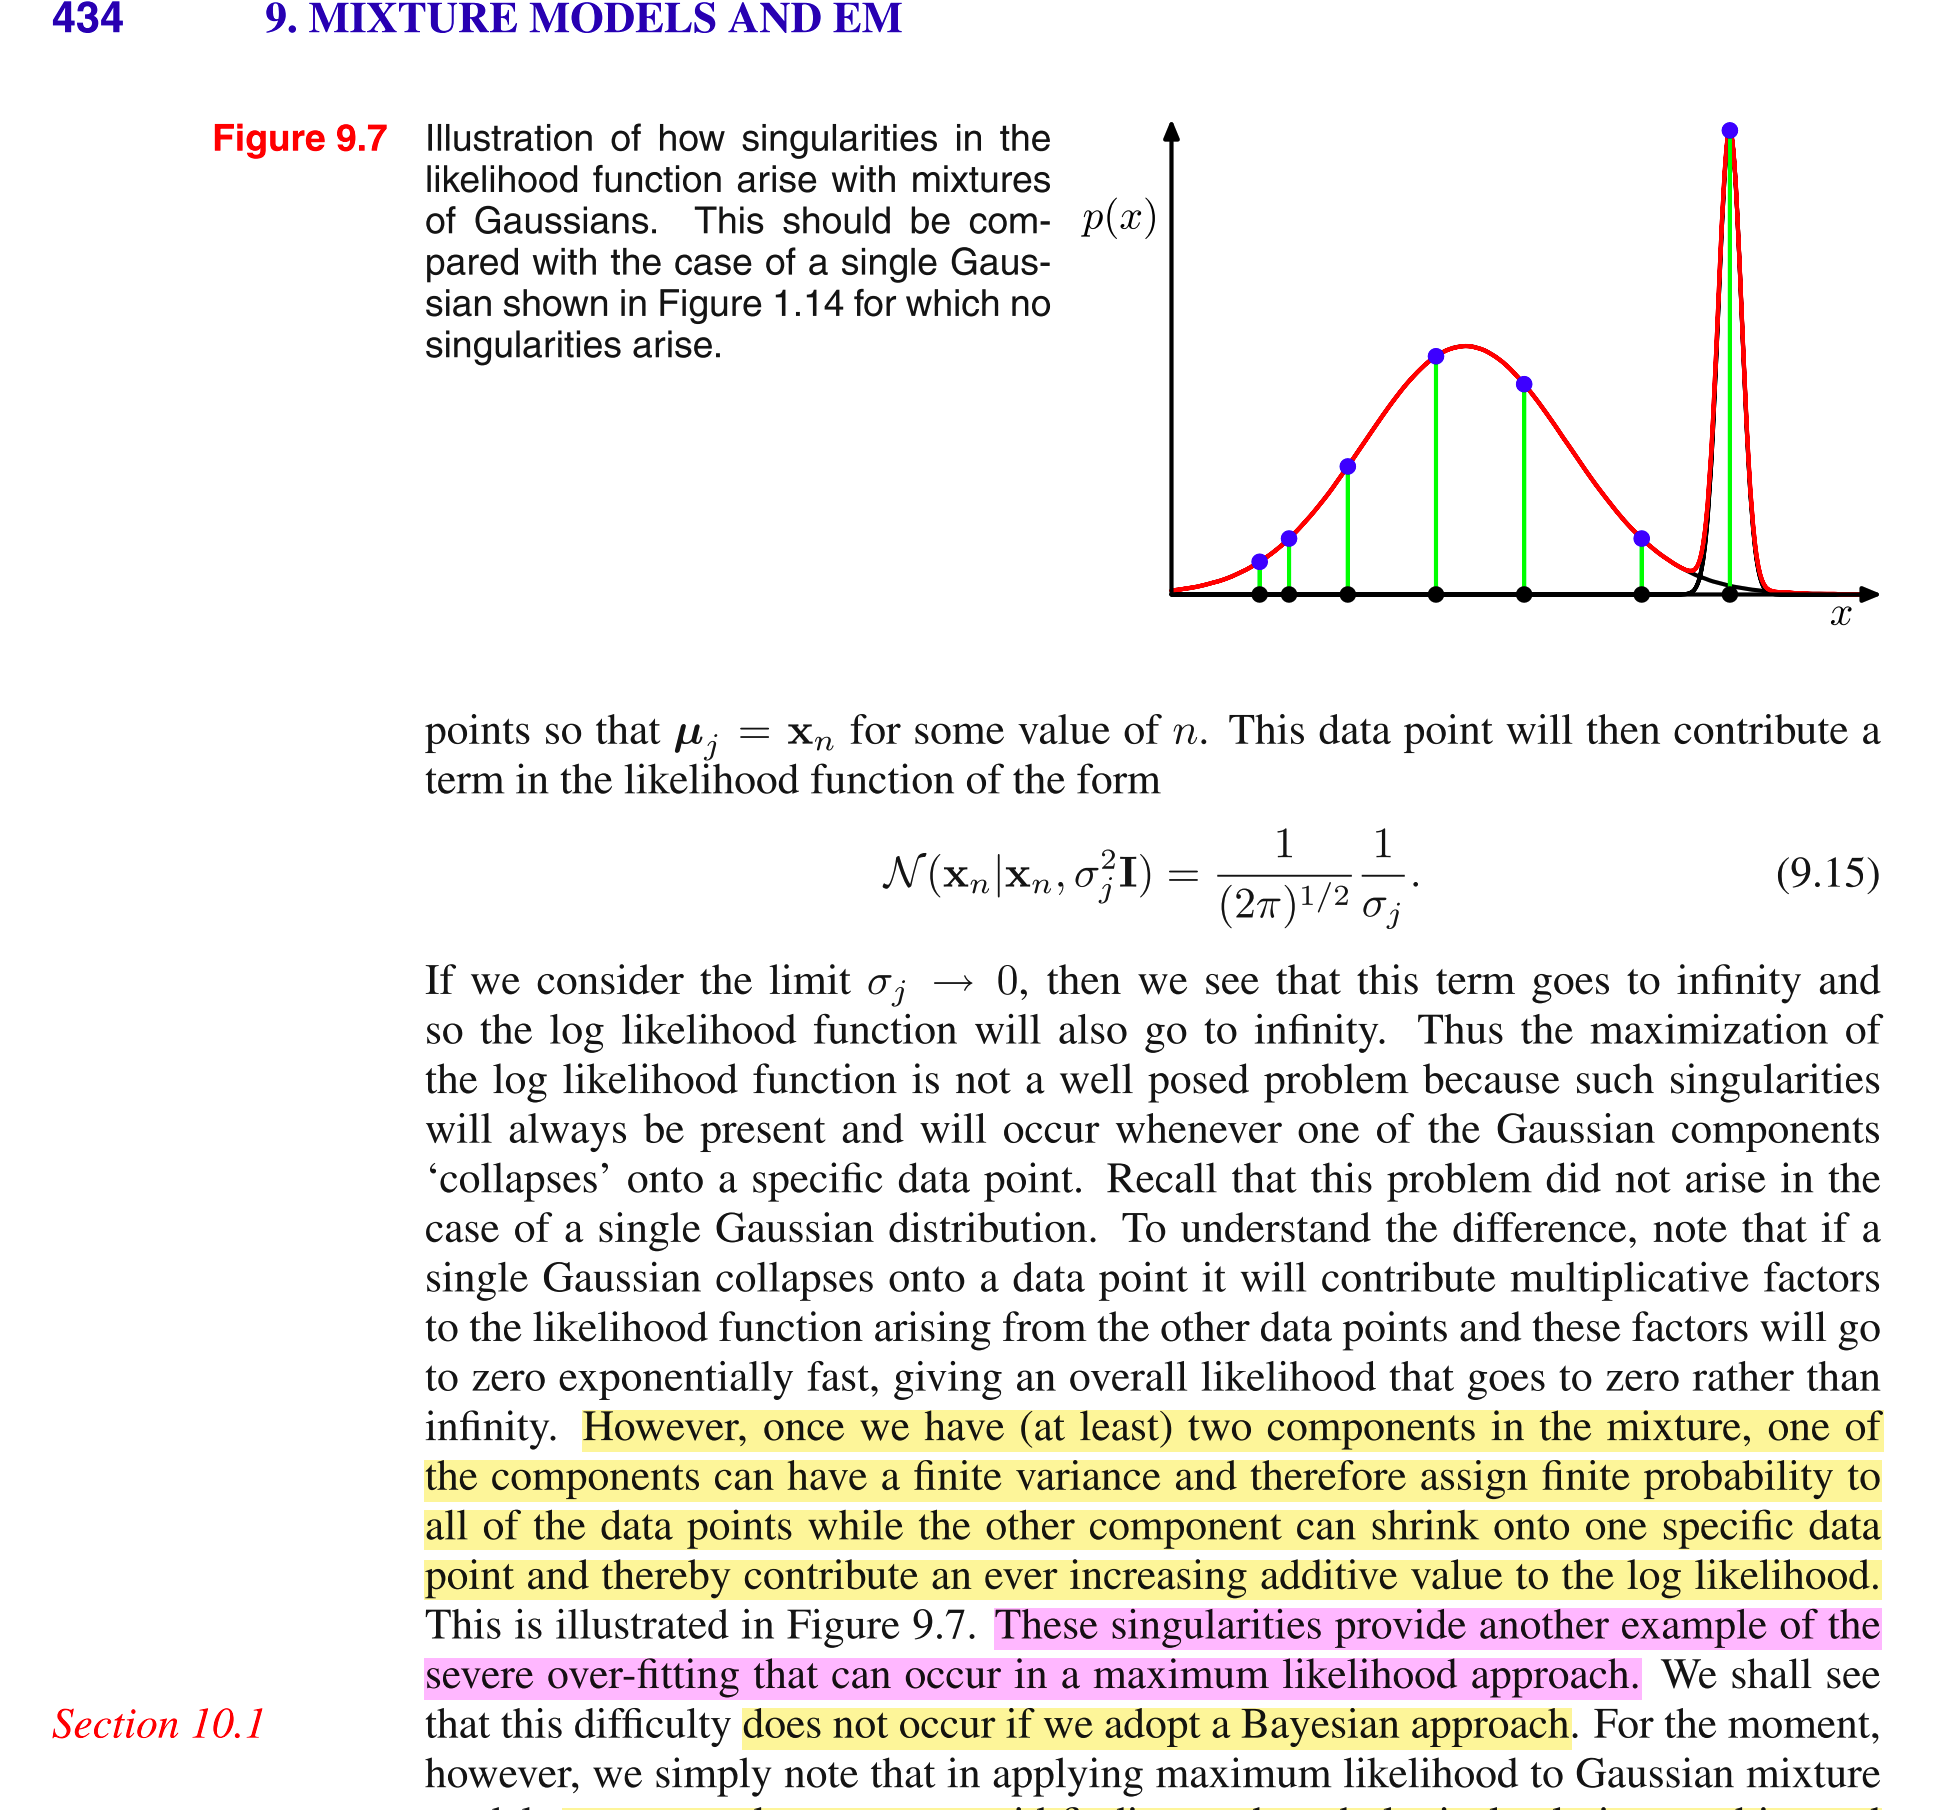
    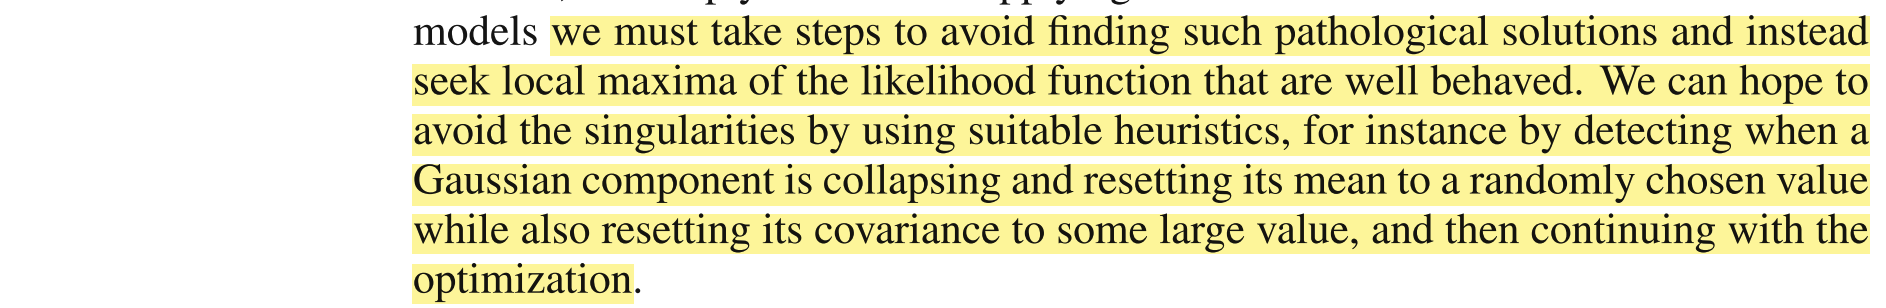

In [ ]:
def demo_singularity_in_mog():
    """See PRML p.434 Fig.9.7"""
    X = torch.tensor([[2., 2.]])
    R = torch.tensor([[0.5,0.5]])
    print("R: ", R)
    print(update_model_params(X, R))
    
demo_singularity_in_mog()
    

In [ ]:
# One iteration
X = torch.tensor(X, dtype=torch.float32)
R = compute_posterior(X, model_params)
new_model = update_model_params(X,R)

In [ ]:
visualize_model(new_model);

- Continuing on Nov 14, 2020

todo:
- [ ] check if the model update is done correctly via visualization

- why is sigma so large and all the same values -- possible broadcasting error
- [ ] make an iteration. Eg.

    ```python
    for ep in range(max_epoches):
        if end_condition:
            break
        # Estep
        R = compute_posterior(X, model_params)

        # Mstep
        model_params = update_params(X,R)

        #Visualize
        visualize_model(model_params)

        # cache to check end condition met
    ```

------------------------------------------------------------------------
- Nov 9, 2020


## Pyro Distributions and Sampling

Shape
- univariate distribution (ie. a prob function of a 1dim/scalar variable): `.event_shape` is empty (`[]`), because there is no dimension(s) that are dependent on computing a probability of the variable.
- multivariate distribution (Eg. a 2dim gaussian is a prob. function of two dimensional variable (ie. a vector of length 2): `.event_shape` == 2 in the 2dim gaussian case.

- Summary    
    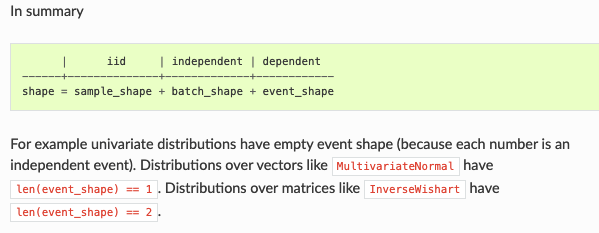
    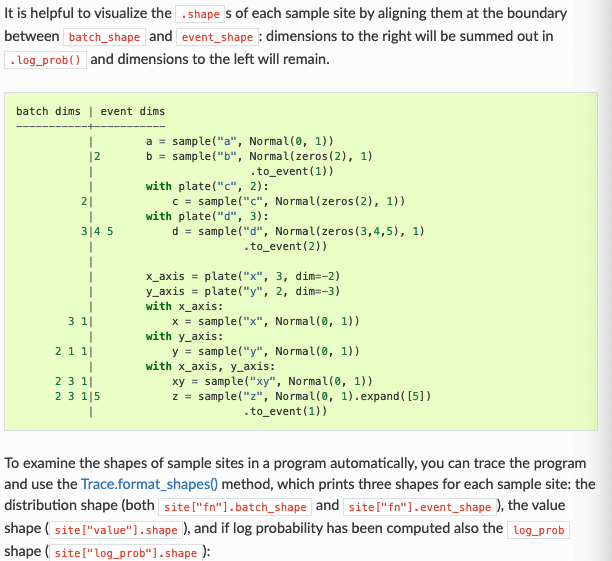


In [ ]:
import pyro
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Normal

In [ ]:
d = Bernoulli(0.1*torch.ones(4,3))
d.batch_shape
x = d.sample()

In [ ]:
d.log_prob(x)

In [ ]:
d.event_dim

In [ ]:
mu = torch.tensor([1.,2.])
cov = torch.eye(2)
cov
gauss2d = MultivariateNormal(mu, cov)

In [ ]:
gauss2d.event_shape #aka. the dimension of the domain of this prob. function
gauss2d.event_shape == (2,)
x = gauss2d.sample()
x.shape


In [ ]:
gauss2d.expand([10]).batch_shape,gauss2d.expand([10]).event_shape

In [ ]:
x = gauss2d.expand([1000]).sample()

plt.scatter(x[:,0], x[:,1], s=10)
plt.scatter(mu[0], mu[1], s=10, c='r')
plt.xlim((-2,5))
plt.ylim((-2,5))